In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cv2 import cv2 as cv
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Load and inspect image

In [2]:
img = plt.imread('tiger.jpg')

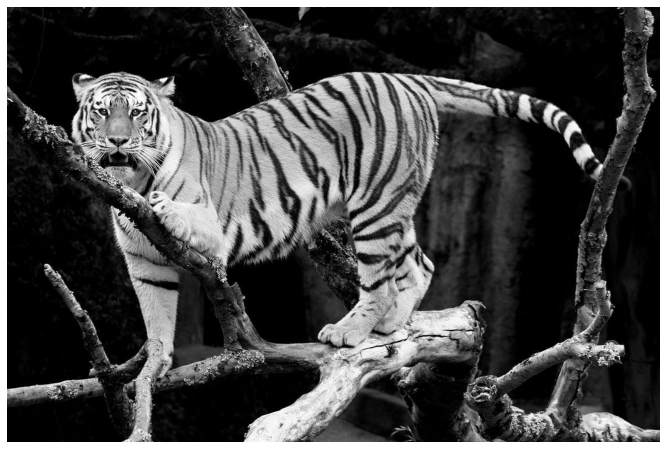

In [3]:
plt.figure(figsize=(15,8))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

In [4]:
img.shape

(853, 1280)

# PART I:  Bilinear interpolation

In [5]:
def resize(img, shape):
    #create an empty array the size of the new image
    resizedImg = np.empty(shape, dtype = np.uint8)
    
    #get the ratio of the original image height to the new image height
    row_ratio = float(img.shape[0]) / float(resizedImg.shape[0])
    
    #get the ratio of the original image width to the new image width
    col_ratio = float(img.shape[1]) / float(resizedImg.shape[1])

    
    #for each pixel in the new resized image, need to find it's location in the original image
    #do this by multiplying it by the ratios
    for row in range(resizedImg.shape[0]):
        for col in range(resizedImg.shape[1]):
            
            r = row * row_ratio
            c = col * col_ratio
            
            #columns are in the x - position 
            x_int = int(c)
            
            #rows are in the y - position
            y_int = int(r)
            
            #calculate difference of ratio from nearest integer pixel location 
            x_diff = c - x_int
            y_diff = r - y_int
            
            #create the 4 corner pixels
            right_column_limit = min(x_int + 1, img.shape[1]-1)
            top_row_limit = min(y_int, img.shape[0] - 1)

            top_left = img[top_row_limit, x_int]
            bottom_left = img[y_int, x_int]
            top_right = img[top_row_limit, right_column_limit]
            bottom_right = img[y_int, right_column_limit]
            
            #interpolate
            bottom = x_diff * bottom_right + (1. - x_diff) * bottom_left
            top = x_diff * top_right + (1. - x_diff) * top_left
            interp = int(y_diff * top + ( 1. - y_diff) * bottom)
            
            
            resizedImg[row][col] = interp
            
    return resizedImg
            

In [6]:
resizedTiger = resize(img, (1500,1500))
print('Resized Image Shape: {}'.format(resizedTiger.shape))

Resized Image Shape: (1500, 1500)


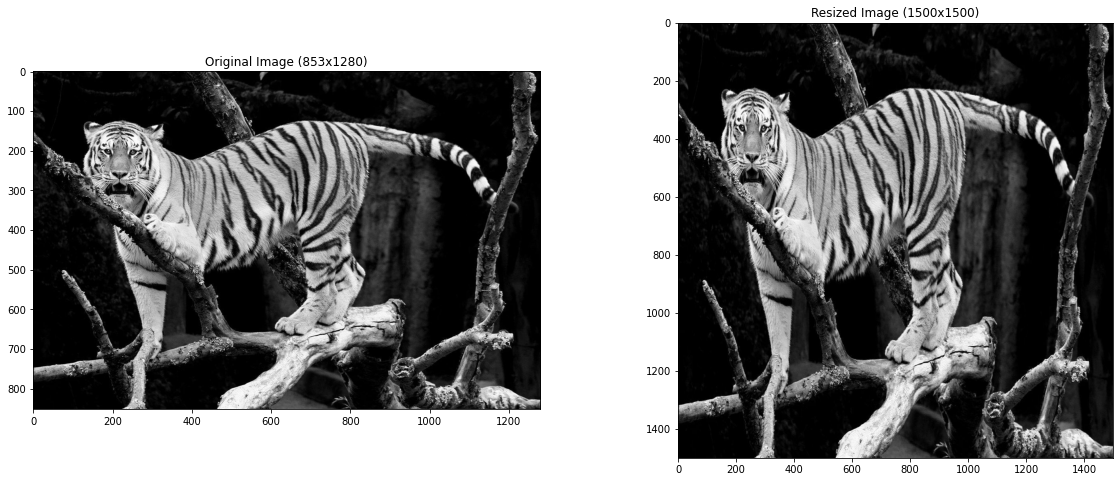

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax1 = plt.subplot(121)
ax1.imshow(img, cmap='gray')
ax1.set_title('Original Image ({}x{})'.format(img.shape[0], img.shape[1]))

ax2 = plt.subplot(122)
ax2.imshow(resizedTiger, cmap='gray')
ax2.set_title('Resized Image ({}x{})'.format(resizedTiger.shape[0], resizedTiger.shape[1]))
plt.show()

# PART II: Histogram Equalization and Histogram Stretching

### Historgram Equalization

In [8]:
#load image 
img = plt.imread('valley.jpg')

#convert the image into a flattened vector
img_flat = img.reshape(-1)

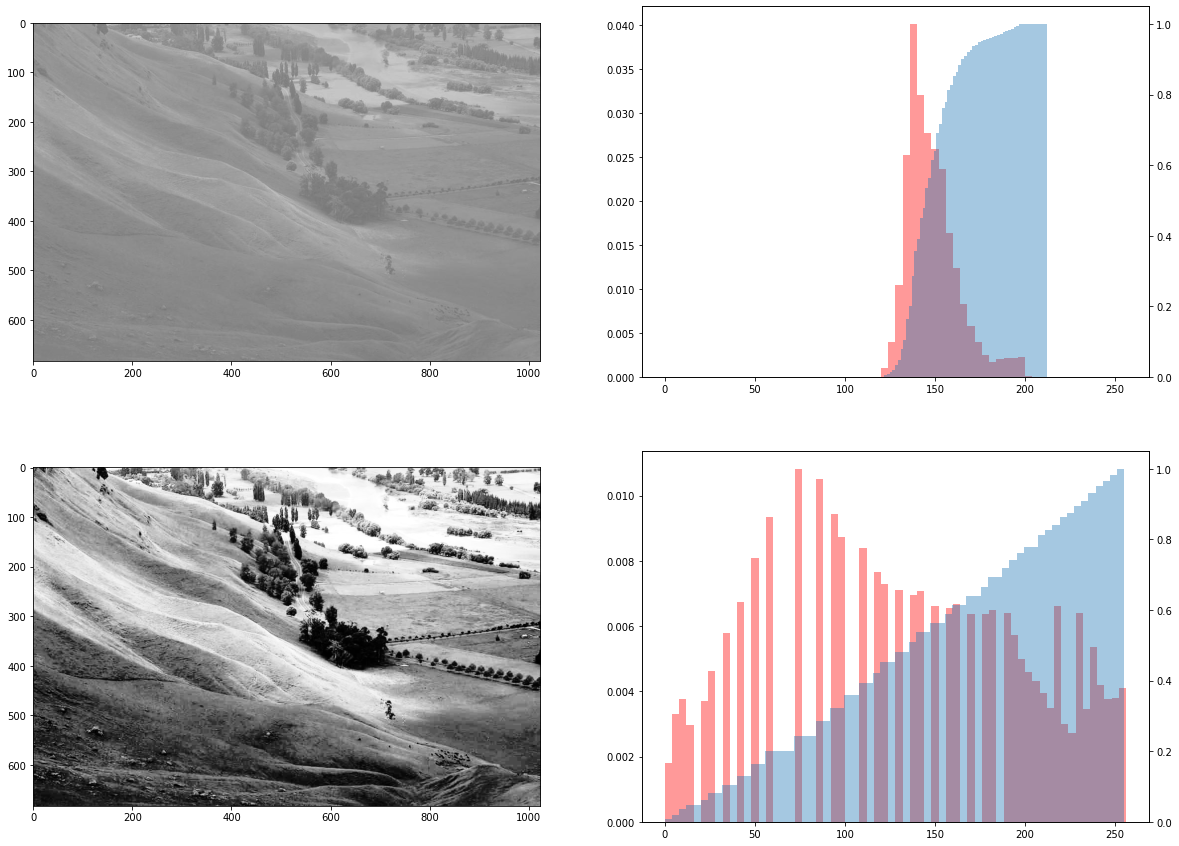

In [9]:
plt.subplots(nrows=2, ncols=2, figsize=(20,15))
plt.subplot(221)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

plt.subplot(222)

# 1.) Compute probability density function (pdf)
plt.hist(img_flat, bins=64, color='red', density=True, alpha=0.4, range=(0,256))
plt.twinx()



# 2.) Compute cumulative distribution function (cdf)
cdf, bins, _ = plt.hist(img_flat, bins=64, density=True, cumulative=True, alpha=0.4)



#3.) Find Transform
#4.) Transform the image by replacing the gray levels of the original image
new_pixels = np.interp(img, bins[:-1], cdf*255)
new_image = new_pixels.reshape(img.shape)


plt.subplot(223)
plt.imshow(new_image, cmap='gray', vmin=0, vmax=255)


#flatten new image into vector of pixels
new_img_flat = np.squeeze(new_image.reshape(-1))

plt.subplot(224)
plt.hist(new_img_flat, bins=64, color='red', density=True, alpha=0.4, range=(0,256))
plt.twinx()

plt.hist(new_img_flat, bins=64, density=True, cumulative=True, alpha=0.4)
plt.show()

### Histogram Stretching

In [10]:
#min pixel intensity
pmin = np.min(img)

#max pixel intensity
pmax = np.max(img)

#lambda
lam = 255

#hist stretching function
stretch = lambda x: ((x - pmin) / (pmax - pmin)) * lam

In [11]:
hs_img = stretch(img)

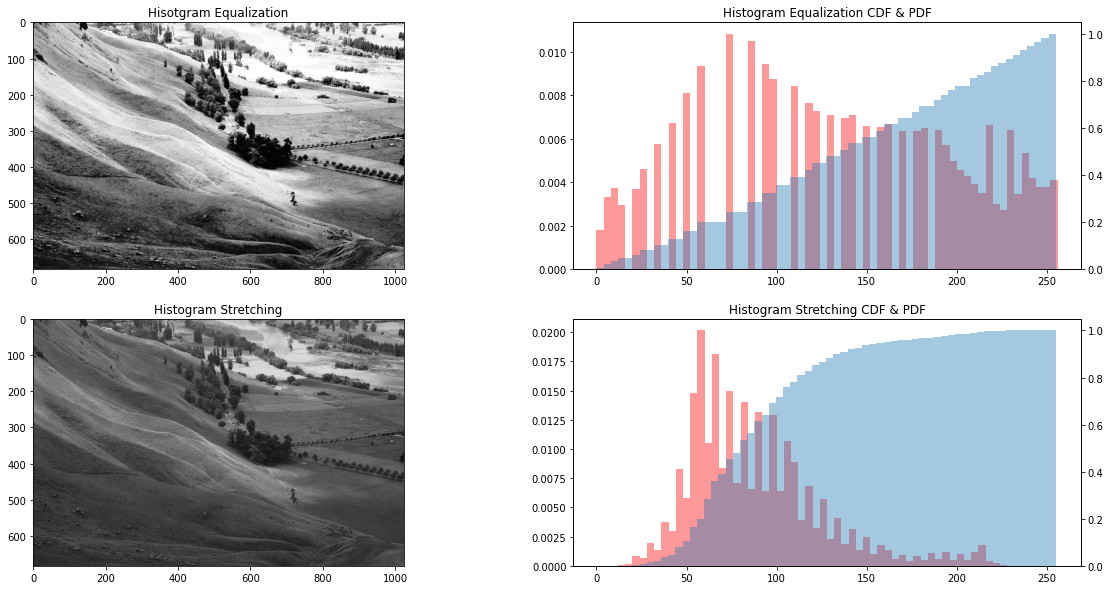

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

plt.subplot(221)
plt.imshow(new_image, cmap='gray')
plt.title('Hisotgram Equalization')

plt.subplot(222)
plt.hist(new_img_flat, bins=64, color='red', density=True, alpha=0.4, range=(0,256))
plt.twinx()

plt.hist(new_img_flat, bins=64, density=True, cumulative=True, alpha=0.4)
plt.title('Histogram Equalization CDF & PDF')


plt.subplot(223)
plt.imshow(hs_img, cmap='gray', vmin=0, vmax=255)
plt.title('Histogram Stretching')

plt.subplot(224)
plt.hist(hs_img.reshape(-1), bins=64, color='red', density=True, alpha=0.4, range=(0,256))
plt.twinx()

plt.hist(hs_img.reshape(-1), bins=64, density=True, cumulative=True, alpha=0.4)
plt.title('Histogram Stretching CDF & PDF')

plt.show()

# Results

Contrast is the difference between maximum and minimum pixel intensity. Histogram Equalization managed to increase the contrast of the image by mapping the pixel intensity histogram from a range of 114 - 212 in the original image to a range of 0 -255. 

Histogram stretching on the other hand, fails to utilize the entire pixel band of 0-255 in this particular instance. This is because histogram stretching is constrained by the max and min pixel values of the original image. Unless the min and max of the image is 0 and 255 respectively, histogram stretching will never utilize the entire 0-255 pixel range. Conversely in the event of a min and max of 0 and 255, histogram stretching simply returns the original image. This is a known short coming of HS, where instead of utilizing the min and max pixel intensities, it is not uncommon to utilize the 5th and 95th percentile intensity